In [9]:
from datasets import *
from train import *
from evaluate import *

from plotting import plot_map, r2_style, mean_style, std_style, corr_style, plot_masked_data
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle

base_folder = "Datasets"
new_folder_iHadCM3 = "Datasets/iHadCM3/Original/"
old_folder = "Datasets_old/iHadCM3/Original"
output_folder = "Output/findbugs"

Following plan: 

Load:
- Old hadCM3 Dataset
- New HadCM3 Dataset
- Old HadCM3 Dataset imported with old method
- Old HadCM3 Dataset imported with new method
    

In [10]:
old_dset = {}
new_dset = {}
y_old_dset = {}
y_new_dset = {}


old_dset["d18O"] = nc.Dataset(os.path.join(new_folder_iHadCM3, "isotopes.nc"))
old_dset["tsurf"] = nc.Dataset(os.path.join(new_folder_iHadCM3, "tsurf.nc"))
old_dset["prec"] = nc.Dataset(os.path.join(new_folder_iHadCM3, "prec.nc"))

new_dset["d18O"] = nc.Dataset(os.path.join(old_folder, "isotopes.nc"))
new_dset["tsurf"] = nc.Dataset(os.path.join(old_folder, "temp.nc"))
new_dset["prec"] = nc.Dataset(os.path.join(old_folder, "precip.nc"))

y_old_dset["d18O"] = nc.Dataset(os.path.join(new_folder_iHadCM3, "isotopes_yearly.nc"))
y_old_dset["tsurf"] = nc.Dataset(os.path.join(new_folder_iHadCM3, "tsurf_yearly.nc"))
y_old_dset["prec"] = nc.Dataset(os.path.join(new_folder_iHadCM3, "prec_yearly.nc"))


y_new_dset["d18O"] = nc.Dataset(os.path.join(old_folder, "isotopes_yearly.nc"))
y_new_dset["tsurf"] = nc.Dataset(os.path.join(old_folder, "temp_yearly.nc"))
y_new_dset["prec"] = nc.Dataset(os.path.join(old_folder, "precip_yearly.nc"))

In [11]:
with gzip.open("Output/findbugs/dset_0x303a9c6fdb130e7f/dataset.gz", 'r') as f:
    ds_new = pickle.load(f)

with gzip.open("Output/findbugs/findbugHadCM3-flat_no-shuffle_1_dO18-precip-temp_1/dataset.gz", 'r') as f:
    ds_old = pickle.load(f)

In [12]:
new_training_set = {}
old_training_set = {}

t_offset=5
new_training_set["d18O"] = ds_new["train"]["targets"][t_offset:,0,...]
new_training_set["tsurf"] = ds_new["train"]["predictors"][t_offset:,0,...]+273.16
new_training_set["prec"] = ds_new["train"]["predictors"][t_offset:,1,...]


old_training_set["d18O"] = ds_old["train"]["targets"][:,0,...]
old_training_set["tsurf"] = ds_old["train"]["predictors"][:,0,...]+273.16
old_training_set["prec"] = ds_old["train"]["predictors"][:,1,...]

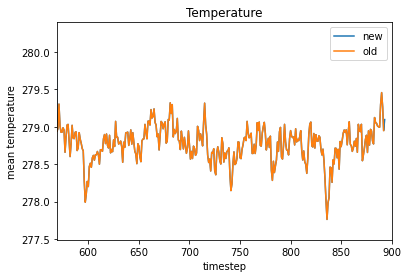

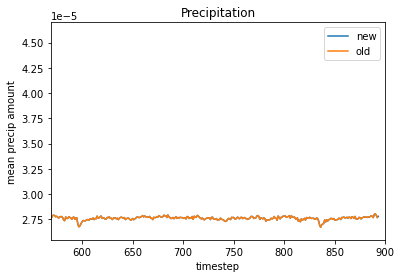

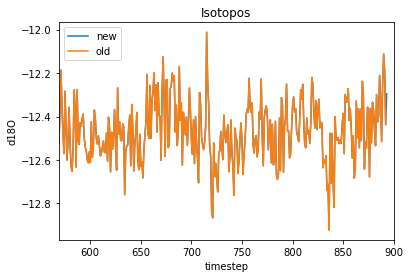

In [13]:
xlims=[569,900]
plt.title("Temperature")
plt.plot(np.mean(new_training_set["tsurf"],axis=(1,2)), label = "new")
plt.plot(np.mean(old_training_set["tsurf"],axis=(1,2)), label = "old")
plt.legend()
plt.xlabel("timestep")
plt.ylabel("mean temperature")
plt.xlim(*xlims)
plt.show()

plt.title("Precipitation")
plt.plot(np.mean(new_training_set["prec"],axis=(1,2)), label = "new")
plt.plot(np.mean(old_training_set["prec"],axis=(1,2)), label = "old")

plt.legend()
plt.xlabel("timestep")
plt.ylabel("mean precip amount")
plt.xlim(*xlims)
plt.show()

plt.title("Isotopos")
plt.plot(np.mean(new_training_set["d18O"],axis=(1,2)), label = "new")
plt.plot(np.mean(old_training_set["d18O"],axis=(1,2)), label = "old")

plt.legend()
plt.xlabel("timestep")
plt.ylabel("d18O")
plt.xlim(*xlims)
plt.show()

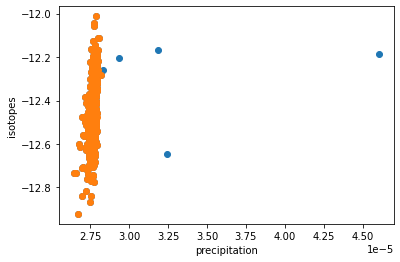

In [14]:
plt.scatter(np.mean(new_training_set["prec"],axis=(1,2)), np.mean(new_training_set["d18O"],axis=(1,2)))
plt.scatter(np.mean(old_training_set["prec"],axis=(1,2)), np.mean(old_training_set["d18O"],axis=(1,2)))
plt.xlabel("precipitation")
plt.ylabel("isotopes")
plt.show()

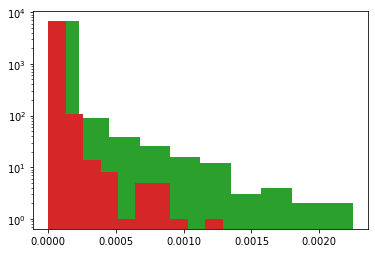

In [15]:
plt.hist(new_training_set["prec"][570,...].ravel())
plt.hist(new_training_set["prec"][569,...].ravel())
plt.hist(new_training_set["prec"][568,...].ravel())
plt.hist(new_training_set["prec"][567,...].ravel())
plt.yscale("log")
plt.show()

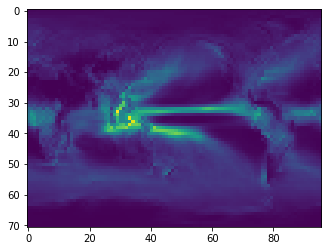

In [16]:
plt.imshow(new_training_set["prec"][570,...])

In [17]:
c_p_old = get_correlation(old_training_set["prec"][:,np.newaxis,...],old_training_set["d18O"][:,np.newaxis,...])[0,...]
c_t_old = get_correlation(old_training_set["tsurf"][:,np.newaxis,...],old_training_set["d18O"][:,np.newaxis,...])[0,...]

max_cor_old = np.amax([abs(c_p_old),abs(c_t_old)], axis=0)
argmax_cor_old = np.argmax([abs(c_p_old),abs(c_t_old)],axis=0)

tas_mask_old = np.where((argmax_cor_old == 1),True,False)
pr_mask_old = np.where((argmax_cor_old == 0),True,False)

tas_img_old = np.ma.masked_array(max_cor_old, np.invert(tas_mask_old))
pr_img_old = np.ma.masked_array(max_cor_old, np.invert(pr_mask_old))

data_dict_old = {"tsurf": tas_img_old,
             "prec": pr_img_old}


In [18]:
c_p_new = get_correlation(new_training_set["prec"][:,np.newaxis,...],new_training_set["d18O"][:,np.newaxis,...])[0,...]
c_t_new = get_correlation(new_training_set["tsurf"][:,np.newaxis,...],new_training_set["d18O"][:,np.newaxis,...])[0,...]

max_cor_new = np.amax([abs(c_p_new),abs(c_t_new)], axis=0)
argmax_cor_new = np.argmax([abs(c_p_new),abs(c_t_new)],axis=0)

tas_mask_new = np.where((argmax_cor_new == 1),True,False)
pr_mask_new = np.where((argmax_cor_new == 0),True,False)

tas_img_new = np.ma.masked_array(max_cor_new, np.invert(tas_mask_new))
pr_img_new = np.ma.masked_array(max_cor_new, np.invert(pr_mask_new))

data_dict_new = {"tsurf": tas_img_new,
             "prec": pr_img_new}

In [19]:
# we need some descriptions for plotting
c = {
    "DATASET_DESCRIPTION": {},
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
}
descriptions, _,_,_ = load_data_for_comparison("Output/Crossprediction/", c)

5 matching runs found


tsurf
prec
tsurf
prec


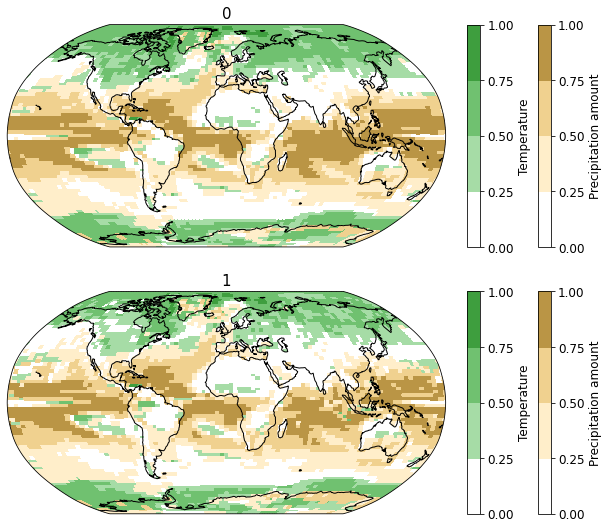

In [20]:
data_dicts = [data_dict_old, data_dict_new]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=corr_style["FIGSIZE"], subplot_kw={'projection': mean_style["PROJECTION"]})
for i in range(2):
    plot_masked_data(ax[i], data_dicts[i], descriptions[1]["DATASET_DESCRIPTION"], corr_style, 
                     title=i)
    
    divider = make_axes_locatable(ax[i])
    for j, key in enumerate(list(data_dicts[i].keys())):
        print(key)
        if j==0:
            ax_cb = divider.new_horizontal(size="3%", pad=0.3, axes_class=plt.Axes)
        else:
            ax_cb = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)            
        fig.add_axes(ax_cb)
        cbar = fig.colorbar(
            matplotlib.cm.ScalarMappable(cmap=corr_style["CMAPS"][key], norm=corr_style["NORM"]),
            spacing='proportional',
            orientation='vertical',
            extend=corr_style["CBAR_EXTEND"], cax=ax_cb)
        cbar.set_label(corr_style["CBAR_LABELS"][key], fontsize=corr_style["CBAR_FONTSIZE"])
        cbar.ax.tick_params(labelsize=corr_style["CBAR_FONTSIZE"])

plt.show()